In [35]:
import torch
import torchvision
import torchvision.transforms as transforms
import urllib
import ssl
import requests



In [36]:
import numpy as np
import pandas as pd
import sys
import cv2

import torch
import torch.nn.functional as F
import torch.nn.init
from torchvision import transforms
from torch.utils.data import Dataset  
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from copy import deepcopy 

In [37]:
# 에러 : <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1108)>
# https://stackoverflow.com/questions/69687794/unable-to-manually-load-cifar10-dataset

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [38]:
### 데이터 세팅


## Transform 선언
random_choice = transforms.RandomChoice([transforms.RandomRotation((0,40)),
                                        transforms.RandomVerticalFlip(0.5),
                                        transforms.RandomHorizontalFlip(0.5)])

transform = transforms.Compose([
#              transforms.Resize(224),
            random_choice,
            transforms.ToTensor(),
        ])
## Transform 선언



batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, 
#                                         transform=transforms.ToTensor(),
                                        transform = transform
                                       )

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, 
                                       transform=transforms.ToTensor(),
#                                        transform = transform
                                      )
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [39]:
trainset.data.shape

(50000, 32, 32, 3)

In [40]:
trainset.data[0].shape

(32, 32, 3)

In [41]:
type(trainset.data[0])

numpy.ndarray

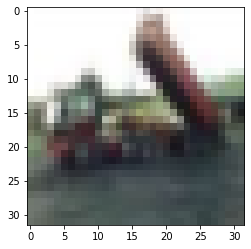

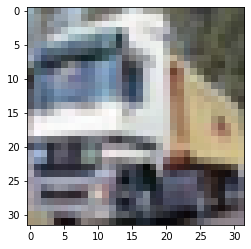

In [42]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(trainset.data[2])
plt.show()

plt.imshow(trainset.data[1])
plt.show()
                        


In [43]:
### 딥한 CNN으로 MNIST 분류   (Early Stop 적용 / Dropout / batchnorm)





device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device,'로 적용됩니다')

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
    
    
learning_rate = 0.01
training_epochs = 200
batch_size = 100
patience = 20  ## 얼리스탑 인자
trigger_n = 0
lowest_cost = np.inf




# CNN 모델 클래스
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        
        # L1 ImgIn shape=(?, 32, 32, 3)
        #    Conv     -> (?, 32, 32, 32)
        #    Pool     -> (?, 16, 16, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # L2 ImgIn shape=(?, 16, 16, 32)
        #    Conv      ->(?, 16, 16, 64)
        #    Pool      ->(?, 8, 8, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        # L3 ImgIn shape=(?, 8, 8, 64)
        #    Conv      ->(?, 8, 8, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.kaiming_normal_( self.fc1.weight, a=0, mode='fan_in', nonlinearity='relu')
#         torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(625),
            torch.nn.Dropout(p=1 - self.keep_prob))
            
        
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.kaiming_normal_( self.fc2.weight, a=0, mode='fan_in', nonlinearity='relu')
#         torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
        self.layer5 = torch.nn.Sequential(
                    self.fc2,
                    )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.layer5(out)
        return out

    
# CNN 모델 정의
model = CNN().to(device)
    
    
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


total_batch = len(trainloader)
print('총 배치의 수 : {}'.format(total_batch))


for epoch in range(training_epochs):
    avg_cost = 0
    
    model.train()

    for X, Y in trainloader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded

        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
        
    ## Early stopping
    
    current_cost = avg_cost
    
    # best model check
    if current_cost < lowest_cost :
        best_epoch = epoch
        lowest_cost = current_cost
        best_model = deepcopy(model.state_dict())
        trigger_n = 0
        
    else:
        trigger_n += 1
        if trigger_n >= patience:
            print("There is no improvement during last %d epochs." % trigger_n)
            break
#     https://blog.naver.com/1012rnjsdydgns/222458085542 참고



    print('[Epoch: {:>4}] cost = {:>.9}, trigger_n: {}, best_epoch: {}'.format(epoch , avg_cost, trigger_n, best_epoch))    
  

  
# Load best epoch's model
model.load_state_dict(best_model)
  

cuda 로 적용됩니다
총 배치의 수 : 12500
[Epoch:    0] cost = 2.17894006, trigger_n: 0, best_epoch: 0
[Epoch:    1] cost = 2.01864171, trigger_n: 0, best_epoch: 1
[Epoch:    2] cost = 1.9343276, trigger_n: 0, best_epoch: 2
[Epoch:    3] cost = 1.8554492, trigger_n: 0, best_epoch: 3
[Epoch:    4] cost = 1.80749834, trigger_n: 0, best_epoch: 4
[Epoch:    5] cost = 1.77388334, trigger_n: 0, best_epoch: 5
[Epoch:    6] cost = 1.75411141, trigger_n: 0, best_epoch: 6
[Epoch:    7] cost = 1.71029031, trigger_n: 0, best_epoch: 7
[Epoch:    8] cost = 1.69182444, trigger_n: 0, best_epoch: 8
[Epoch:    9] cost = 1.6682173, trigger_n: 0, best_epoch: 9
[Epoch:   10] cost = 1.64430559, trigger_n: 0, best_epoch: 10
[Epoch:   11] cost = 1.62479699, trigger_n: 0, best_epoch: 11
[Epoch:   12] cost = 1.61073577, trigger_n: 0, best_epoch: 12
[Epoch:   13] cost = 1.58826625, trigger_n: 0, best_epoch: 13
[Epoch:   14] cost = 1.58234036, trigger_n: 0, best_epoch: 14
[Epoch:   15] cost = 1.55368018, trigger_n: 0, best_ep

[Epoch:  132] cost = 1.23776984, trigger_n: 1, best_epoch: 131
[Epoch:  133] cost = 1.23835325, trigger_n: 2, best_epoch: 131
[Epoch:  134] cost = 1.23637569, trigger_n: 3, best_epoch: 131
[Epoch:  135] cost = 1.23050332, trigger_n: 0, best_epoch: 135
[Epoch:  136] cost = 1.23706007, trigger_n: 1, best_epoch: 135
[Epoch:  137] cost = 1.23738945, trigger_n: 2, best_epoch: 135
[Epoch:  138] cost = 1.22784913, trigger_n: 0, best_epoch: 138
[Epoch:  139] cost = 1.23823154, trigger_n: 1, best_epoch: 138
[Epoch:  140] cost = 1.23206592, trigger_n: 2, best_epoch: 138
[Epoch:  141] cost = 1.2304827, trigger_n: 3, best_epoch: 138
[Epoch:  142] cost = 1.22723913, trigger_n: 0, best_epoch: 142
[Epoch:  143] cost = 1.22150111, trigger_n: 0, best_epoch: 143
[Epoch:  144] cost = 1.23898411, trigger_n: 1, best_epoch: 143
[Epoch:  145] cost = 1.21488523, trigger_n: 0, best_epoch: 145
[Epoch:  146] cost = 1.24376595, trigger_n: 1, best_epoch: 145
[Epoch:  147] cost = 1.22561431, trigger_n: 2, best_epoc

<All keys matched successfully>

In [44]:
with torch.no_grad():
    
    model.eval()   ## 배치놈 인퍼런스 계산까지 포함됨 (평균, 편차, 감마, 베타 모두)
    
#     X_val = torch.FloatTensor(x_val).view(len(x_val), 1, 28, 28).float().to(device)
#     Y_val = torch.FloatTensor(y_val).to(device)

    prediction = model(testloader)
    correct_prediction = torch.argmax(prediction, 1) == Y_val
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

TypeError: conv2d() received an invalid combination of arguments - got (DataLoader, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mDataLoader[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mDataLoader[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
